### Test2

In [1]:
print("a")

a


0. 特徴量エクスポート

In [8]:
# ================================
# Cell 0 — HAR
# : C:\qiskit-python\QFF2025\data\QRC\swaption_features.csv
# ================================
import os, pathlib, re
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# CSV
SRC_CSV = "./Dataset_Simulated_Price_swaption.csv"

def ensure_feature_outpath():
    win_dir  = r"C:\qiskit-python\QFF2025\data\QRC"
    posix_dir = "./data/QRC"
    outdir = win_dir if os.name == "nt" else posix_dir
    pathlib.Path(outdir).mkdir(parents=True, exist_ok=True)
    return os.path.join(outdir, "swaption_features.csv")

FEATURE_OUT = ensure_feature_outpath()

# --- Date/数値化/欠損 ---
df0 = pd.read_csv(SRC_CSV, engine="python", sep=None)
DATE_COL = next((c for c in df0.columns[::-1] if str(c).strip().lower()=="date"), df0.columns[-1])
df0[DATE_COL] = pd.to_datetime(df0[DATE_COL], errors="coerce")
feat_cols = [c for c in df0.columns if c != DATE_COL]
df_num = df0.copy()
df_num[feat_cols] = df_num[feat_cols].apply(pd.to_numeric, errors="coerce")
df_num[feat_cols] = df_num[feat_cols].ffill().bfill()  # ver3 と同じ埋め

# --- Tenor/Maturity を列名から抽出 ---
HEADER_BIPAT = r"Tenor\s*:\s*([0-9.+\-eE]+)\s*;\s*Maturity\s*:\s*([0-9.+\-eE]+)"
TENOR_PAT = r"Tenor\s*:\s*([0-9.+\-eE]+)(?=\s*;)"
MATU_PAT  = r"Maturity\s*:\s*([0-9.+\-eE]+)"
Tenor, Maturity = [], []
for c in feat_cols:
    s = str(c)
    m = re.search(HEADER_BIPAT, s)
    if m:
        t = float(m.group(1).strip(" ,;")); u = float(m.group(2).strip(" ,;"))
    else:
        m1, m2 = re.search(TENOR_PAT, s), re.search(MATU_PAT, s)
        if m1 and m2:
            t = float(m1.group(1).strip(" ,;")); u = float(m2.group(1).strip(" ,;"))
        else:
            nums = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", s)
            t, u = (float(nums[0]), float(nums[1])) if len(nums)>=2 else (np.nan, np.nan)
    Tenor.append(t); Maturity.append(u)
Tenor = np.array(Tenor, float); Maturity = np.array(Maturity, float)

# --- Cross-sectional 指標・HAR ---
X    = df_num[feat_cols].values.astype(float)
Xlog = np.log1p(X)
cs_mean = X.mean(axis=1)
cs_std  = X.std(axis=1)

# 日ごとに p_t ≈ a + b_T*T + b_M*M を OLS で近似
H = np.column_stack([np.ones_like(Tenor), Tenor, Maturity])
def day_slopes(y):
    b, *_ = np.linalg.lstsq(H, y, rcond=None)  # b=[a, b_T, b_M]
    return b[1], b[2]
slope_T, slope_M = zip(*[day_slopes(X[t]) for t in range(X.shape[0])])
slope_T = np.array(slope_T); slope_M = np.array(slope_M)

ret   = np.diff(Xlog, axis=0, prepend=Xlog[[0], :])
r_bar = ret.mean(axis=1)
absr  = np.abs(r_bar)
rv22  = pd.Series(r_bar**2).rolling(22, min_periods=1).mean().values
rq22  = pd.Series(r_bar**4).rolling(22, min_periods=1).mean().values
bpv22 = (np.pi/2.0) * (pd.Series(absr).shift(1)*pd.Series(absr)).rolling(22, min_periods=1).mean().values
absr_1 = absr
absr_5 = pd.Series(absr).rolling(5, min_periods=1).mean().values

cs_ma22 = pd.Series(cs_mean).rolling(22, min_periods=1).mean().values
trend_22 = cs_mean - cs_ma22

# --- PCA(3) と PC1 の 22MA ---
sc  = StandardScaler().fit(X)
Z   = sc.transform(X)
pca = PCA(n_components=3, random_state=0).fit(Z)
PC  = pca.transform(Z)
pc1_ma22 = pd.Series(PC[:,0]).rolling(22, min_periods=1).mean().values

# --- 出力（ver3のカラム構成） ---
feat_df = pd.DataFrame({
    "Date": df_num[DATE_COL].values,
    "PC1": PC[:,0], "PC2": PC[:,1], "PC3": PC[:,2],
    "CrossSecMean": cs_mean, "CrossSecStd": cs_std,
    "SlopeTenor": slope_T, "SlopeMaturity": slope_M,
    "RV22": rv22, "RQ22": rq22, "BPV22": bpv22,
    "AbsR_1": absr_1, "AbsR_5": absr_5,
    "CS_MA22": cs_ma22, "Trend22": trend_22,
    "PC1_MA22": pc1_ma22
})
feat_df.to_csv(FEATURE_OUT, index=False)
print(f"[FEATURES] saved to: {FEATURE_OUT}")
print("[FEATURES] columns:", list(feat_df.columns))


[FEATURES] saved to: C:\qiskit-python\QFF2025\data\QRC\swaption_features.csv
[FEATURES] columns: ['Date', 'PC1', 'PC2', 'PC3', 'CrossSecMean', 'CrossSecStd', 'SlopeTenor', 'SlopeMaturity', 'RV22', 'RQ22', 'BPV22', 'AbsR_1', 'AbsR_5', 'CS_MA22', 'Trend22', 'PC1_MA22']


1. 関数定義

In [9]:
# ================================
# Cell 1 — 関数定義群
# ================================
import os, re, time, math, pathlib
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# --- Timer/IO ---
class Timer:
    def __init__(self, label=""): self.label = label
    def __enter__(self): self.t0 = time.perf_counter(); return self
    def __exit__(self, *exc):
        if self.label: print(f"[TIMER] {self.label}: {time.perf_counter()-self.t0:.2f}s")

def rmse_(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:  # sklearn古い環境向け
        return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def ensure_outdir():
    win_dir = r"C:\qiskit-python\QFF2025\outputs\QRC"
    posix_dir = "./outputs/QRC"
    outdir = win_dir if os.name == "nt" else posix_dir
    pathlib.Path(outdir).mkdir(parents=True, exist_ok=True)
    print(f"[IO] Export directory = {outdir}")
    return outdir

def savefig(path, dpi=300):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight"); print(f"[SAVE] {path}")
    plt.show()

def save_table(df: pd.DataFrame, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df.to_csv(path, index=False); print(f"[SAVE] {path}")

# --- CSV読み込み & マスク ---
HEADER_BIPAT = r"Tenor\s*:\s*([0-9.+\-eE]+)\s*;\s*Maturity\s*:\s*([0-9.+\-eE]+)"
TENOR_PAT = r"Tenor\s*:\s*([0-9.+\-eE]+)(?=\s*;)"
MATU_PAT  = r"Maturity\s*:\s*([0-9.+\-eE]+)"

def read_swaption_csv_with_mask(csv_path: str):
    df = pd.read_csv(csv_path, engine="python", sep=None)
    date_col = next((c for c in df.columns[::-1] if str(c).strip().lower()=="date"), df.columns[-1])
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    feature_cols = [c for c in df.columns if c != date_col]
    df_num = df.copy()
    df_num[feature_cols] = df_num[feature_cols].apply(pd.to_numeric, errors="coerce")
    df_num[feature_cols] = df_num[feature_cols].ffill().bfill()
    mask_obs = ~df_num[feature_cols].isna().values  # 補間後の状態で確定
    return df_num, date_col, feature_cols, mask_obs

# --- 外生（セル0の特徴量） ---
def read_exog_features(exog_csv_path: str, date_col_name: str = "Date", drop_cols: List[str] = ("TARGET",)):
    if not os.path.exists(exog_csv_path):
        print(f"[INFO] exog file not found: {exog_csv_path} (skip)")
        return None
    ex = pd.read_csv(exog_csv_path)
    if date_col_name not in ex.columns:
        cand = [c for c in ex.columns if str(c).strip().lower()=="date"]
        date_col_name = cand[0] if cand else ex.columns[0]
    ex[date_col_name] = pd.to_datetime(ex[date_col_name], errors="coerce")
    for d in drop_cols:
        if d in ex.columns: ex = ex.drop(columns=[d])
    num_cols = [c for c in ex.columns if c != date_col_name]
    ex[num_cols] = ex[num_cols].apply(pd.to_numeric, errors="coerce")
    return ex, date_col_name

def align_and_make_exog_matrix(df_base: pd.DataFrame, DATE_COL: str, exog_df: pd.DataFrame, exog_date_col: str,
                               use_cols: Optional[List[str]] = None, fill_method: str = "ffill_bfill"):
    base = df_base[[DATE_COL]].copy()
    ex = exog_df.copy()
    keep = [c for c in (use_cols if use_cols is not None else [c for c in ex.columns if c != exog_date_col]) if c in ex.columns]
    merged = base.merge(ex[[exog_date_col]+keep], how="left", left_on=DATE_COL, right_on=exog_date_col).drop(columns=[exog_date_col])
    if fill_method:
        if "ffill" in fill_method: merged[keep] = merged[keep].ffill()
        if "bfill" in fill_method: merged[keep] = merged[keep].bfill()
    merged[keep] = merged[keep].fillna(0.0)
    X_exog = merged[keep].values.astype(float)  # (T, D)
    return X_exog, keep

def make_exog_design_for_forecast(X_exog_all: np.ndarray, W: int, H: int, lags: List[int], N_all_fore: int):
    # t=W..W+N_all_fore-1 に対し、各ラグの exog[t - L] を縦結合
    T, D = X_exog_all.shape
    feats = np.zeros((N_all_fore, D*len(lags)), float)
    for i in range(N_all_fore):
        t = W + i
        off = 0
        for L in lags:
            tL = max(0, t - L)
            feats[i, off:off+D] = X_exog_all[tL]
            off += D
    return feats  # (N_all_fore, D*|lags|)

# --- Tenor/Maturity → 基底 Φ(T,M) ---
def parse_tenor_maturity_from_headers(cols: List[str]) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    T_list, M_list, bad = [], [], []
    for c in cols:
        s = str(c)
        m = re.search(HEADER_BIPAT, s)
        if m:
            t = float(m.group(1).strip(" ,;")); u = float(m.group(2).strip(" ,;"))
        else:
            m1, m2 = re.search(TENOR_PAT, s), re.search(MATU_PAT, s)
            if m1 and m2:
                t = float(m1.group(1).strip(" ,;")); u = float(m2.group(1).strip(" ,;"))
            else:
                nums = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", s)
                if len(nums) >= 2: t, u = float(nums[0]), float(nums[1])
                else: t, u = np.nan, np.nan; bad.append(s)
        T_list.append(t); M_list.append(u)
    if bad: print(f"[WARN] Tenor/Maturity parse failed for {len(bad)} cols (ex: {bad[:3]})")
    return np.array(T_list, float), np.array(M_list, float), np.arange(len(cols))

def _normalize_pm1(x: np.ndarray):
    x = np.asarray(x, float); mn, mx = np.nanmin(x), np.nanmax(x)
    if not np.isfinite(mn) or not np.isfinite(mx) or mx == mn: return np.zeros_like(x)
    return 2.0*(x - mn)/(mx - mn) - 1.0

def build_phi_poly(tenors: np.ndarray, maturities: np.ndarray, degree: int = 2, include_cross: bool = True):
    Tn = _normalize_pm1(tenors); Mn = _normalize_pm1(maturities)
    parts, names = [np.ones_like(Tn)], ["1"]
    parts += [Tn, Mn]; names += ["T", "M"]
    parts += [Tn**2, Mn**2]; names += ["T2", "M2"]
    if include_cross: parts += [Tn*Mn]; names += ["TxM"]
    if degree >= 3:
        parts += [Tn**3, Mn**3]; names += ["T3", "M3"]
    Phi = np.vstack(parts).T; Phi[~np.isfinite(Phi)] = 0.0
    return Phi, names

def pinv_colwise(Phi: np.ndarray) -> np.ndarray:
    return np.linalg.pinv(Phi)  # (K,F)

def project_to_beta(X_scaled_all: np.ndarray, A: np.ndarray) -> np.ndarray:
    return X_scaled_all @ A.T  # (T,K)

def reconstruct_from_beta(beta_like: np.ndarray, Phi: np.ndarray) -> np.ndarray:
    shp = beta_like.shape; K = Phi.shape[1]
    b2 = beta_like.reshape(-1, K) @ Phi.T
    F = Phi.shape[0]
    return b2.reshape(*(shp[:-1]), F)

def fit_scaler(X_all: np.ndarray, cut_train_end: int):
    scaler = StandardScaler().fit(X_all[:cut_train_end])
    Xs = scaler.transform(X_all)
    Xs = _clean_array(Xs)          # ★ ここで非有限・極端値を除去
    return scaler, Xs

def fit_pca_for_beta(beta_all: np.ndarray, cut_train_end: int, n_qubits: int):
    n_components_eff = min(n_qubits, beta_all.shape[1], max(1, beta_all[:cut_train_end].shape[0]-1))
    pca = PCA(n_components=n_components_eff, random_state=42).fit(beta_all[:cut_train_end])
    return pca, pca.transform(beta_all)

def make_windows(X_any_all: np.ndarray, W: int) -> np.ndarray:
    return np.asarray([X_any_all[t-W:t] for t in range(W, len(X_any_all))], float)

def build_targets_beta(beta_all: np.ndarray, W: int, H: int, target_mode="delta"):
    T, K = beta_all.shape
    idx = []; Ys = []; bases = []
    for t in range(W, T - H):
        base = beta_all[t]
        ys = []
        for h in range(1, H+1):
            y = beta_all[t+h]
            ys.append(y - base if target_mode == "delta" else y)
        idx.append(t); Ys.append(np.stack(ys, axis=0)); bases.append(base)
    return np.array(idx, int), np.asarray(Ys, float), np.asarray(bases, float)

# --- QRC（StatevectorでRyエンコード → ミキサ）---
@dataclass
class QRCParams:
    n_qubits: int = 6
    depth: int = 2
    kappa_in: float = 1.0
    seed: int = 7

def _mix_layer(qc: QuantumCircuit, params: QRCParams):
    n, d = params.n_qubits, params.depth
    for _ in range(d):
        for q in range(n): qc.rz((q+1)*0.07, q)
        for q in range(n-1): qc.cx(q, q+1)
        qc.cx(n-1, 0)
        for q in range(n): qc.rx((q+1)*0.13, q)

def _z_or_pair(sv: Statevector, n_qubits: int, use_pair: bool):
    probs = sv.probabilities_dict()
    expZ = np.zeros(n_qubits)
    for bit, p in probs.items():
        br = bit[::-1]
        for i in range(n_qubits):
            expZ[i] += p*(+1.0 if br[i]=='0' else -1.0)
    if not use_pair: return expZ
    zz = []
    for i in range(n_qubits):
        for j in range(i+1, n_qubits):
            acc = 0.0
            for bit, p in probs.items():
                br = bit[::-1]
                zi = +1.0 if br[i]=='0' else -1.0
                zj = +1.0 if br[j]=='0' else -1.0
                acc += p*(zi*zj)
            zz.append(acc)
    return np.concatenate([expZ, np.asarray(zz, float)])

def qrc_features_timesliced(windows_r: np.ndarray, params: QRCParams, use_pair=False):
    N, W, n = windows_r.shape
    D1 = n if not use_pair else n + n*(n-1)//2
    feats = np.empty((N, W*D1), float)
    for k in range(N):
        qc = QuantumCircuit(n, name="qrc_ts")
        offs = 0
        for s in range(W):
            for q in range(n):
                qc.ry(params.kappa_in * windows_r[k, s, q], q)
            _mix_layer(qc, params)
        sv = Statevector.from_instruction(qc)
        feats[k, offs:offs+D1] = _z_or_pair(sv, n, use_pair)
        offs += D1
    return feats

def standardize_features(X_feats: np.ndarray, idx_train: slice):
    # train 部分で平均・分散を決める。NaN/±infを事前に無害化
    tr = X_feats[idx_train]
    tr = np.nan_to_num(tr, nan=0.0, posinf=0.0, neginf=0.0)
    mu = np.nanmean(tr, axis=0)
    sd = np.nanstd(tr, axis=0)
    sd[~np.isfinite(sd)] = 1.0
    sd[sd == 0] = 1.0

    def tfm(x):
        x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        return (x - mu) / sd
    return tfm


# --- β空間 → 価格空間の復元（Δ/level 両対応）---
def make_reconstructor_for_price(scaler_X: StandardScaler, Phi: np.ndarray, apply_log1p: bool):
    def to_price_from_beta(y_like, base_beta=None, mode="delta"):
        if y_like.ndim == 2:
            yb = (base_beta + y_like) if mode=="delta" else y_like
            v_scaled = reconstruct_from_beta(yb, Phi)
            v_unscaled = scaler_X.inverse_transform(v_scaled)
            return np.expm1(v_unscaled) if apply_log1p else v_unscaled
        else:
            Nloc, Hloc, K = y_like.shape
            yb = (base_beta[:, None, :] + y_like) if mode=="delta" else y_like
            v_scaled = reconstruct_from_beta(yb, Phi)
            v_unscaled = scaler_X.inverse_transform(v_scaled.reshape(Nloc*Hloc, -1)).reshape(Nloc, Hloc, -1)
            return np.expm1(v_unscaled) if apply_log1p else v_unscaled
    return to_price_from_beta

# --- ベースライン（Last/RW） ---
def baselines_multiH(X_raw, idx_slice, W, H, N_all_fore):
    idxs = list(range(*idx_slice.indices(N_all_fore)))
    Nloc, F = len(idxs), X_raw.shape[1]
    last = np.zeros((Nloc, H, F)); rw = np.zeros((Nloc, H, F))
    for ii, i in enumerate(idxs):
        t_idx = W + i
        x_t, x_tm1 = X_raw[t_idx], X_raw[t_idx-1]
        for h in range(1, H+1):
            last[ii, h-1, :] = x_t
            rw[ii, h-1, :]   = x_t + h*(x_t - x_tm1)
    return last, rw

def summarize_price_3d(true_price, pred_price):
    Nloc, Hloc, Floc = true_price.shape
    rows = []
    for h in range(Hloc):
        rows.append({"horizon": h+1,
                     "MAE": mean_absolute_error(true_price[:, h, :], pred_price[:, h, :]),
                     "RMSE": rmse_(true_price[:, h, :], pred_price[:, h, :])})
    return pd.DataFrame(rows)

# --- 可視化 ---
def plot_rmse_vs_h(df_dict: Dict[str, pd.DataFrame], title="RMSE per horizon"):
    plt.figure(figsize=(7,4))
    for name, df_h in df_dict.items():
        plt.plot(df_h["horizon"], df_h["RMSE"], marker="o", label=name)
    plt.xlabel("Horizon (days)"); plt.ylabel("RMSE"); plt.title(title); plt.grid(True); plt.legend()

def parity_plot(y_true: np.ndarray, y_pred: np.ndarray, title: str="Parity"):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true.ravel(), y_pred.ravel(), s=6, alpha=0.4)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, '--', linewidth=1)
    plt.title(title); plt.xlabel("True"); plt.ylabel("Pred"); plt.grid(True)

def error_hist(y_true: np.ndarray, y_pred: np.ndarray, title="Error histogram"):
    err = (y_pred - y_true).ravel()
    plt.figure(figsize=(6,3))
    plt.hist(err, bins=60, alpha=0.8)
    plt.title(title); plt.xlabel("Pred - True"); plt.ylabel("count"); plt.grid(True)

def rmse_heatmap_by_grid(y_true: np.ndarray, y_pred: np.ndarray, feature_cols: List[str], title="RMSE heatmap"):
    from collections import defaultdict
    err2 = (y_true - y_pred)**2
    rmse_vec = np.sqrt(err2.mean(axis=0))
    tenors, maturities, _ = parse_tenor_maturity_from_headers(feature_cols)
    valid = np.isfinite(tenors) & np.isfinite(maturities)
    rmse_v = rmse_vec[valid]
    T_v = np.round(tenors[valid], 12); M_v = np.round(maturities[valid], 12)
    idx_by_pair = defaultdict(list)
    for i, (t, m) in enumerate(zip(T_v, M_v)):
        idx_by_pair[(float(t), float(m))].append(i)
    unique_pairs = sorted(idx_by_pair.keys())
    T_vals = sorted({t for (t, _) in unique_pairs}); M_vals = sorted({m for (_, m) in unique_pairs})
    Tn, Mn = len(T_vals), len(M_vals); U = len(unique_pairs)
    if Tn*Mn == U and Tn>0 and Mn>0:
        pos_T = {t:i for i,t in enumerate(T_vals)}; pos_M = {m:i for i,m in enumerate(M_vals)}
        mat = np.zeros((Tn, Mn), dtype=float)
        for (t,m), id_list in idx_by_pair.items():
            mat[pos_T[t], pos_M[m]] = float(np.mean(rmse_v[id_list]))
        plt.figure(figsize=(5,4)); plt.imshow(mat, aspect='auto'); plt.title(title)
        plt.xlabel("Maturity"); plt.ylabel("Tenor"); plt.colorbar()
    else:
        plt.figure(figsize=(8,2)); plt.plot(rmse_v); plt.title(title+" (flat)"); plt.grid(True)

def plot_forecast_overlay_with_baselines(dates_by_h, true_te, pred_te_qrc, pred_te_last, pred_te_rw,
                                         feature_cols, horizon_idx=0, top_k=3, title_prefix="Forecast (QRC vs Naive)"):
    k = min(top_k, len(feature_cols)); d = dates_by_h[horizon_idx]
    for i in range(k):
        plt.figure(figsize=(10,4))
        plt.plot(d, true_te[:, horizon_idx, i], label=f"True: {feature_cols[i]}")
        plt.plot(d, pred_te_qrc[:, horizon_idx, i], label="QRC")
        plt.plot(d, pred_te_last[:, horizon_idx, i], label="NaiveLast")
        plt.plot(d, pred_te_rw[:, horizon_idx, i], label="NaiveRW")
        plt.title(f"{title_prefix} — {feature_cols[i]} (h={horizon_idx+1})")
        plt.xlabel("Date"); plt.ylabel("Price"); plt.grid(True); plt.legend()

def _clean_array(a, clip=1e6):
     a = np.asarray(a, dtype=np.float64)
     a = np.nan_to_num(a, nan=0.0, posinf=0.0, neginf=0.0)
     if clip is not None:
         a = np.clip(a, -clip, clip)
     return a



2. 学習群

In [10]:
# ================================
# Cell 2 — Forecast (ver3 multi‑H)
# ================================
CSV_PATH = "./Dataset_Simulated_Price_swaption.csv"
EXOG_CSV_PATH = (r"C:\qiskit-python\QFF2025\data\QRC\swaption_features.csv"
                 if os.name == "nt" else "./data/QRC/swaption_features.csv")

APPLY_LOG1P = True
N_QUBITS = 6
DEPTH    = 2
SEED     = 7

# ver3 既定
CFG_FC = {
    3:  {"W": 20, "degree": 2, "use_pair": False},
    14: {"W": 30, "degree": 3, "use_pair": True},
}
EXOG_LAGS  = [0, 1, 5, 22]      # ← 固定ラグ（ver3）
KAPPA_GRID = (1.0, 2.0)         # 軽い探索
ALPHA_GRID = (1e-3,1e-2,1e-1,1.0,3.0,10.0)

OUTDIR = ensure_outdir()

# 0) base
df, DATE_COL, feature_cols, mask_obs = read_swaption_csv_with_mask(CSV_PATH)
X_raw_full = df[feature_cols].values.astype(float)
dates_all  = pd.to_datetime(df[DATE_COL].values)
T, F = X_raw_full.shape
print(f"[DATA] T={T}, F={F}, DATE_COL='{DATE_COL}'")

# 1) Φ(T,M)
tenors, maturities, _ = parse_tenor_maturity_from_headers(feature_cols)

# 2) exog（ver3列だけ使用）
exog_pack = read_exog_features(EXOG_CSV_PATH, date_col_name="Date", drop_cols=("TARGET",))
if exog_pack is not None:
    exog_df, exog_date_col = exog_pack
    EXOG_COLS = ["PC1","PC2","PC3","CrossSecMean","CrossSecStd",
                 "SlopeTenor","SlopeMaturity",
                 "RV22","RQ22","BPV22","AbsR_1","AbsR_5",
                 "CS_MA22","Trend22","PC1_MA22"]
    X_exog_all, used_exog_cols = align_and_make_exog_matrix(df, DATE_COL, exog_df, exog_date_col, EXOG_COLS)
    print(f"[EXOG] columns used: {used_exog_cols} (D={len(used_exog_cols)})")
else:
    X_exog_all, used_exog_cols = None, []

# ---------------- Imputation (Δ; ver3そのまま) ----------------
def run_imputation_residual(df_filled, mask_obs, *, W=20, degree=2,
                            n_qubits=6, depth=2, use_pair=False,
                            kappa_grid=(1.0, 2.0),
                            alpha_grid=(1e-3,1e-2,1e-1,1.0,3.0,10.0),
                            seed=7):
    X_raw = df_filled[feature_cols].values.astype(float)
    X_raw = np.nan_to_num(X_raw, nan=0.0, posinf=0.0, neginf=0.0)
    Tloc, Floc = X_raw.shape
    N_all = Tloc - W
    assert N_all > 40

    # split
    idx_tr = slice(0, int(N_all*0.70))
    idx_va = slice(idx_tr.stop, idx_tr.stop + int(N_all*0.15))
    idx_te = slice(idx_va.stop, N_all)
    cut_end = W + idx_tr.stop

    # Φ→β→PCA
    Phi, _ = build_phi_poly(tenors, maturities, degree=degree, include_cross=True)
    X_all = np.log1p(X_raw) if APPLY_LOG1P else X_raw.copy()
    X_all[~np.isfinite(X_all)] = 0.0
    scaler, X_scaled = fit_scaler(X_all, cut_end)
    A = pinv_colwise(Phi); beta = project_to_beta(X_scaled, A)
    pca, B_red = fit_pca_for_beta(beta, cut_end, n_qubits=n_qubits)
    win_all = make_windows(B_red, W); win = win_all[:N_all]; nq_eff = win.shape[2]
    params = QRCParams(n_qubits=nq_eff, depth=depth, kappa_in=1.0, seed=seed)

    # Δ（prev + Δ̂ で戻す）
    Y_level = X_scaled[W:]; Y_base = X_scaled[W-1:-1]
    Y_delta = Y_level - Y_base
    Obs_t, Obs_tm1 = mask_obs[W:], mask_obs[W-1:-1]
    Obs_ok = Obs_t & Obs_tm1

    # Val/Test 20% マスク
    rng = np.random.default_rng(seed)
    Hold_va = np.zeros_like(Obs_ok[idx_va], dtype=bool)
    Hold_te = np.zeros_like(Obs_ok[idx_te], dtype=bool)
    for f in range(Floc):
        iova = np.where(Obs_ok[idx_va, f])[0]; rng.shuffle(iova); k = int(len(iova)*0.20); Hold_va[iova[:k], f] = True
        iote = np.where(Obs_ok[idx_te, f])[0]; rng.shuffle(iote); k = int(len(iote)*0.20); Hold_te[iote[:k], f] = True

    best = {"rmse": np.inf}
    with Timer("Imputation (Δ): Hyper parameter search"):
        for kappa in kappa_grid:
            params.kappa_in = kappa
            X_feats_all = qrc_features_timesliced(win, params, use_pair=use_pair)
            tfm = standardize_features(X_feats_all, idx_tr)
            Xz = _clean_array(tfm(X_feats_all))
            X_tr, X_va = _clean_array(Xz[idx_tr]), _clean_array(Xz[idx_va])
            Y_tr, Y_va = _clean_array(Y_delta[idx_tr]), _clean_array(Y_delta[idx_va])
            for alpha in alpha_grid:
                mdl = Ridge(alpha=alpha, fit_intercept=True).fit(X_tr, Y_tr)
                pred_va_delta = mdl.predict(X_va)
                idxm = np.where(Hold_va)
                rmse_val = rmse_(Y_va[idxm], pred_va_delta[idxm]) if len(idxm[0])>0 else np.inf
                if np.isfinite(rmse_val) and rmse_val < best["rmse"]:
                    best = {"rmse": rmse_val, "kappa": kappa, "alpha": alpha, "tfm": tfm, "X_feats_all": X_feats_all}

    X_feats_all = best["X_feats_all"]; tfm = best["tfm"]; Xz = tfm(X_feats_all)
    X_tr, X_va, X_te = _clean_array(Xz[idx_tr]), _clean_array(Xz[idx_va]), _clean_array(Xz[idx_te])
    Y_tr, Y_va, Y_te = _clean_array(Y_delta[idx_tr]), _clean_array(Y_delta[idx_va]), _clean_array(Y_delta[idx_te])

    with Timer("Imputation (Δ): Train final & predict"):
        mdl = Ridge(alpha=best["alpha"], fit_intercept=True).fit(X_tr, Y_tr)
        pred_va_delta = mdl.predict(X_va)
        pred_te_delta = mdl.predict(X_te)
        pred_all_delta = mdl.predict(Xz)

    def inv_space(y_scaled_2d):
        y_unscaled = scaler.inverse_transform(y_scaled_2d)
        return (np.expm1(y_unscaled) if APPLY_LOG1P else y_unscaled)

    true_va_price = inv_space(Y_level[idx_va]); true_te_price = inv_space(Y_level[idx_te])
    pred_va_price = inv_space(Y_base[idx_va] + pred_va_delta)
    pred_te_price = inv_space(Y_base[idx_te] + pred_te_delta)
    base_val_prev = inv_space(Y_base[idx_va]); base_te_prev = inv_space(Y_base[idx_te])

    def masked_metrics(y_true, y_pred, mask):
        idx = np.where(mask)
        return {
            "MAE":  mean_absolute_error(y_true[idx], y_pred[idx]) if len(idx[0])>0 else np.nan,
            "RMSE": rmse_(y_true[idx], y_pred[idx]) if len(idx[0])>0 else np.nan,
            "count": int(len(idx[0])),
        }

    m_val = masked_metrics(true_va_price, pred_va_price, Hold_va)
    m_te  = masked_metrics(true_te_price,  pred_te_price,  Hold_te)
    m_val_base = masked_metrics(true_va_price, base_val_prev, Hold_va)
    m_te_base  = masked_metrics(true_te_price,  base_te_prev,  Hold_te)

    # 完成パネル（確認用）
    Y_level_all = X_scaled[W:].copy(); Y_base_all = X_scaled[W-1:-1].copy(); Obs_all = mask_obs[W:]
    miss_idx = np.where(~Obs_all)
    Y_level_completed = Y_level_all.copy()
    Y_level_completed[miss_idx] = (Y_base_all + pred_all_delta)[miss_idx]
    completed_price = inv_space(Y_level_completed)
    head_price      = X_raw_full[:W]
    full_completed_price = np.vstack([head_price, completed_price])
    imputed_df = pd.DataFrame(full_completed_price, columns=feature_cols)
    imputed_df.insert(0, DATE_COL, dates_all.values)

    return {
        "kappa": best["kappa"], "alpha": best["alpha"], "nq_eff": win.shape[2],
        "val_masked": m_val, "test_masked": m_te,
        "val_masked_baseline": m_val_base, "test_masked_baseline": m_te_base,
        "imputed_df": imputed_df, "dates_all": dates_all,
        "idx_val": idx_va, "idx_test": idx_te,
        "true_val_holdout": true_va_price[np.where(Hold_va)],
        "pred_val_holdout": pred_va_price[np.where(Hold_va)],
        "true_test_holdout": true_te_price[np.where(Hold_te)],
        "pred_test_holdout": pred_te_price[np.where(Hold_te)],
    }

with Timer("RUN — Imputation (Δ)"):
    IMP = run_imputation_residual(df, mask_obs,
                                  W=20, degree=2,
                                  n_qubits=N_QUBITS, depth=DEPTH, use_pair=False,
                                  kappa_grid=KAPPA_GRID, alpha_grid=ALPHA_GRID,
                                  seed=SEED)

# ---------------- Forecast（multi‑H; ver3） ----------------
def run_forecast_with_exog_improved(W, H, degree, use_pair):
    N_all_fore = T - W - H
    assert N_all_fore > 40

    # split
    idx_train = slice(0, int(N_all_fore*0.70))
    idx_val   = slice(idx_train.stop, idx_train.stop + int(N_all_fore*0.15))
    idx_test  = slice(idx_val.stop, N_all_fore)
    cut_train_end = W + idx_train.stop

    # Φ→β→PCA
    Phi, basis_names = build_phi_poly(tenors, maturities, degree=degree, include_cross=True)
    X_all  = np.log1p(X_raw_full) if APPLY_LOG1P else X_raw_full.copy()
    scaler_X, X_scaled_all = fit_scaler(X_all, cut_train_end)
    A = pinv_colwise(Phi); beta_all = project_to_beta(X_scaled_all, A)
    pca_beta, B_reduced_all = fit_pca_for_beta(beta_all, cut_train_end, n_qubits=N_QUBITS)
    nq_eff = B_reduced_all.shape[1]
    windows_r_all = make_windows(B_reduced_all, W)
    windows_r     = windows_r_all[:N_all_fore]
    _, Y_beta, base_beta = build_targets_beta(beta_all, W=W, H=H, target_mode="delta")
    to_price = make_reconstructor_for_price(scaler_X, Phi, APPLY_LOG1P)

    # exog（固定ラグ）
    if X_exog_all is not None:
        X_exog_design_all = make_exog_design_for_forecast(X_exog_all, W=W, H=H, lags=EXOG_LAGS, N_all_fore=N_all_fore)
        scaler_ex = StandardScaler().fit(X_exog_design_all[idx_train])
        X_exog_z  = _clean_array(scaler_ex.transform(X_exog_design_all))
    else:
        X_exog_z = None

    params = QRCParams(n_qubits=nq_eff, depth=DEPTH, kappa_in=1.0, seed=SEED)
    print(f"[INFO] Forecast: W={W}, H={H}, qubits={nq_eff}, depth={DEPTH}, use_pair={use_pair}, EXOG={'on' if X_exog_z is not None else 'off'}")
    print(f"[INFO] Factor head: degree={degree} → nq_eff={nq_eff}")

    # 探索
    best = {"rmse": np.inf}
    with Timer("Forecast: Hyper parameter search (kappa×alpha)"):
        for kappa in KAPPA_GRID:
            params.kappa_in = kappa
            X_qrc_all = _clean_array(qrc_features_timesliced(windows_r, params, use_pair=use_pair))
            tfm = standardize_features(X_qrc_all, idx_train)
            X_qrc_z = _clean_array(tfm(X_qrc_all))
            Xz_all  = np.hstack([X_qrc_z, X_exog_z]) if X_exog_z is not None else X_qrc_z
            X_tr, X_va = Xz_all[idx_train], Xz_all[idx_val]
            Y_tr = Y_beta[idx_train].reshape(len(range(*idx_train.indices(N_all_fore))), H*beta_all.shape[1])
            Y_va = Y_beta[idx_val].reshape(  len(range(*idx_val.indices(N_all_fore))),   H*beta_all.shape[1])
            base_va = base_beta[idx_val]
            for alpha in ALPHA_GRID:
                mdl = Ridge(alpha=alpha, fit_intercept=True).fit(X_tr, Y_tr)
                pred_va_flat = mdl.predict(X_va)
                pred_va_beta = pred_va_flat.reshape(X_va.shape[0], H, beta_all.shape[1])
                true_va_price = to_price(Y_beta[idx_val], base_va, mode="delta")
                pred_va_price = to_price(pred_va_beta, base_va, mode="delta")
                rmse_mean = rmse_(true_va_price.reshape(-1, F), pred_va_price.reshape(-1, F))
                if rmse_mean < best["rmse"]:
                    best = {"rmse": rmse_mean, "kappa": kappa, "alpha": alpha, "tfm": tfm,
                            "X_qrc_all": X_qrc_all, "X_exog_z": X_exog_z}

    # 学習・予測
    X_qrc_all = best["X_qrc_all"]; tfm = best["tfm"]; X_qrc_z = tfm(X_qrc_all)
    Xz_all = np.hstack([X_qrc_z, best["X_exog_z"]]) if best["X_exog_z"] is not None else X_qrc_z
    X_tr, X_va, X_te = Xz_all[idx_train], Xz_all[idx_val], Xz_all[idx_test]
    Y_tr = Y_beta[idx_train].reshape(len(range(*idx_train.indices(N_all_fore))), H*beta_all.shape[1])
    Y_va = Y_beta[idx_val].reshape(  len(range(*idx_val.indices(N_all_fore))),   H*beta_all.shape[1])
    Y_te = Y_beta[idx_test].reshape( len(range(*idx_test.indices(N_all_fore))),  H*beta_all.shape[1])
    base_tr, base_va, base_te = base_beta[idx_train], base_beta[idx_val], base_beta[idx_test]

    with Timer("Forecast: Train final Ridge & predict"):
        mdl = Ridge(alpha=best["alpha"], fit_intercept=True).fit(X_tr, Y_tr)
        pred_va_flat = mdl.predict(X_va)
        pred_te_flat = mdl.predict(X_te)
        pred_va_beta = pred_va_flat.reshape(X_va.shape[0], H, beta_all.shape[1])
        pred_te_beta = pred_te_flat.reshape(X_te.shape[0], H, beta_all.shape[1])

    true_va_price = to_price(Y_beta[idx_val], base_va, mode="delta")
    true_te_price = to_price(Y_beta[idx_test], base_te, mode="delta")
    pred_va_price = to_price(pred_va_beta, base_va, mode="delta")
    pred_te_price = to_price(pred_te_beta, base_te, mode="delta")

    # Naive
    last_va, rw_va = baselines_multiH(X_raw_full, idx_val,  W, H, N_all_fore)
    last_te, rw_te = baselines_multiH(X_raw_full, idx_test, W, H, N_all_fore)

    df_val_qrc = summarize_price_3d(true_va_price, pred_va_price)
    df_te_qrc  = summarize_price_3d(true_te_price,  pred_te_price)
    df_val_last = summarize_price_3d(true_va_price, last_va)
    df_val_rw   = summarize_price_3d(true_va_price, rw_va)
    df_te_last  = summarize_price_3d(true_te_price,  last_te)
    df_te_rw    = summarize_price_3d(true_te_price,  rw_te)

    Nte = true_te_price.shape[0]
    dates_by_h = [ pd.to_datetime(dates_all)[ (W + idx_test.start + h) : (W + idx_test.start + h + Nte) ]
                   for h in range(1, H+1) ]

    return {
        "kappa": best["kappa"], "alpha": best["alpha"], "nq_eff": nq_eff,
        "true_va": true_va_price, "pred_va": pred_va_price,
        "true_te": true_te_price, "pred_te": pred_te_price,
        "last_te": last_te, "rw_te": rw_te,
        "df_val": {"QRC": df_val_qrc, "NaiveLast": df_val_last, "NaiveRW": df_val_rw},
        "df_te":  {"QRC": df_te_qrc,  "NaiveLast": df_te_last,  "NaiveRW": df_te_rw},
        "dates_by_h": dates_by_h, "feature_cols": feature_cols
    }

# 実行（H=14, H=3）
ART_FC = {}
for H in (14, 3):
    cfg = CFG_FC[H]
    with Timer(f"RUN — Forecast H={H}"):
        FC = run_forecast_with_exog_improved(W=cfg["W"], H=H, degree=cfg["degree"], use_pair=cfg["use_pair"])
    print(f"\n=== Forecast (H={H}) — QRC vs Baselines ===")
    print(f"kappa={FC['kappa']}, alpha={FC['alpha']}, nq_eff={FC['nq_eff']}, depth={DEPTH}, EXOG={'on' if X_exog_all is not None else 'off'}")
    print("[Validation] QRC / Last / RW (RMSE mean):",
          f"{FC['df_val']['QRC']['RMSE'].mean():.6f} / {FC['df_val']['NaiveLast']['RMSE'].mean():.6f} / {FC['df_val']['NaiveRW']['RMSE'].mean():.6f}")
    print("[Test] QRC / Last / RW (RMSE mean):",
          f"{FC['df_te']['QRC']['RMSE'].mean():.6f} / {FC['df_te']['NaiveLast']['RMSE'].mean():.6f} / {FC['df_te']['NaiveRW']['RMSE'].mean():.6f}")
    ART_FC[H] = FC

ART_MODEL = {
    f"H{H}": {
        "QRC": ART_FC[H]["df_te"]["QRC"]["RMSE"].mean(),
        "NaiveLast": ART_FC[H]["df_te"]["NaiveLast"]["RMSE"].mean(),
        "NaiveRW":   ART_FC[H]["df_te"]["NaiveRW"]["RMSE"].mean(),
    } for H in (14,3)
}


[IO] Export directory = C:\qiskit-python\QFF2025\outputs\QRC
[DATA] T=500, F=224, DATE_COL='Date'
[EXOG] columns used: ['PC1', 'PC2', 'PC3', 'CrossSecMean', 'CrossSecStd', 'SlopeTenor', 'SlopeMaturity', 'RV22', 'RQ22', 'BPV22', 'AbsR_1', 'AbsR_5', 'CS_MA22', 'Trend22', 'PC1_MA22'] (D=15)
[TIMER] Imputation (Δ): Hyper parameter search: 11.67s
[TIMER] Imputation (Δ): Train final & predict: 0.00s
[TIMER] RUN — Imputation (Δ): 11.68s
[INFO] Forecast: W=30, H=14, qubits=6, depth=2, use_pair=True, EXOG=on
[INFO] Factor head: degree=3 → nq_eff=6
[TIMER] Forecast: Hyper parameter search (kappa×alpha): 16.87s
[TIMER] Forecast: Train final Ridge & predict: 0.00s
[TIMER] RUN — Forecast H=14: 16.92s

=== Forecast (H=14) — QRC vs Baselines ===
kappa=2.0, alpha=1.0, nq_eff=6, depth=2, EXOG=on
[Validation] QRC / Last / RW (RMSE mean): 0.016754 / 0.015652 / 0.032773
[Test] QRC / Last / RW (RMSE mean): 0.014214 / 0.010119 / 0.027576
[INFO] Forecast: W=20, H=3, qubits=6, depth=2, use_pair=False, EXOG=on

In [17]:
# ================================
# Cell 2b — H=3 専用：n_qubits スイープ（3,6,9,12,20）
#  - ver3 の関数群（Cell 1/2）に依存
#  - Test の h=3 の MSE を集計
#  - 出力: table_qubits_vs_mse_H3.csv / fig_qubits_vs_mse_H3.png
# ================================
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# ---- (1) 実行トグル（必要に応じて True/False を切替） ----
QSWEEP_TOGGLE = {3: True, 4: True, 5: True, 6: True, 8: True, 10: True, 12: True, 14: True, 16: True}

# ---- (2) H=3 の既定（ver3 と整合） ----
H = 3
W = 20
USE_PAIR = False                 # ver3: H=3 は False（軽量） :contentReference[oaicite:3]{index=3}
EXOG_LAGS_USE = [0, 1, 5, 22]    # ver3: 固定ラグ                       :contentReference[oaicite:4]{index=4}
KAPPA_GRID_SWEEP = (1.0, 2.0)    # ver3: 軽い探索                       :contentReference[oaicite:5]{index=5}
ALPHA_GRID_SWEEP = (1e-3, 1e-2, 1e-1, 1.0, 3.0, 10.0)

# ---- (3) Φ の「全単項」版（a+b<=d の T^a M^b をすべて使う） ----
def build_phi_poly_full(tenors: np.ndarray, maturities: np.ndarray, degree: int = 2):
    Tn = _normalize_pm1(tenors); Mn = _normalize_pm1(maturities)
    parts, names = [], []
    for a in range(degree+1):
        for b in range(degree+1 - a):
            parts.append((Tn**a) * (Mn**b))
            if a==0 and b==0: names.append("1")
            elif b==0:        names.append("T" if a==1 else f"T{a}")
            elif a==0:        names.append("M" if b==1 else f"M{b}")
            else:             names.append(f"T{a}M{b}")
    Phi = np.vstack(parts).T
    Phi[~np.isfinite(Phi)] = 0.0
    return Phi, names

def min_degree_for_qubits(nq: int) -> int:
    # K(d) = (d+1)(d+2)/2 が nq を超える最小 d を返す
    d = 2
    while (d+1)*(d+2)//2 < int(max(1, nq)):
        d += 1
    return d

# ---- (4) データ/Exog の用意（Cell 2 が未実行でも動くよう冗長に） ----
if 'df' not in globals():
    df, DATE_COL, feature_cols, mask_obs = read_swaption_csv_with_mask(CSV_PATH)
    X_raw_full = df[feature_cols].values.astype(float)
    dates_all  = pd.to_datetime(df[DATE_COL].values)
tenors, maturities, _ = parse_tenor_maturity_from_headers(feature_cols)

if 'X_exog_all' not in globals():
    exog_pack = read_exog_features(EXOG_CSV_PATH, date_col_name="Date", drop_cols=("TARGET",))
    if exog_pack is not None:
        exog_df, exog_date_col = exog_pack
        EXOG_COLS = ["PC1","PC2","PC3","CrossSecMean","CrossSecStd",
                     "SlopeTenor","SlopeMaturity",
                     "RV22","RQ22","BPV22","AbsR_1","AbsR_5",
                     "CS_MA22","Trend22","PC1_MA22"]
        X_exog_all, used_exog_cols = align_and_make_exog_matrix(df, DATE_COL, exog_df, exog_date_col, EXOG_COLS)
    else:
        X_exog_all = None

# ---- (5) 実験関数：n_qubits を指定して H=3 を 1回走らせる ----
def run_H3_qubit_experiment(n_qubits: int, verbose: bool = True):
    t0 = time.perf_counter()
    # split（ver3 と同じ 70/15/15） :contentReference[oaicite:6]{index=6}
    N_all_fore = len(X_raw_full) - W - H
    idx_train = slice(0, int(N_all_fore*0.70))
    idx_val   = slice(idx_train.stop, idx_train.stop + int(N_all_fore*0.15))
    idx_test  = slice(idx_val.stop, N_all_fore)
    cut_train_end = W + idx_train.stop

    # Φ を n_qubits に応じて拡張（a+b<=d の全単項）
    degree_sweep = min_degree_for_qubits(n_qubits)
    Phi, basis_names = build_phi_poly_full(tenors, maturities, degree=degree_sweep)

    if verbose:
        print(f"\n[QSWEEP] n_qubits={n_qubits} | basis degree={degree_sweep} (K={Phi.shape[1]}) | W={W}, H={H}, use_pair={USE_PAIR}")
        if n_qubits >= 16:
            print("[QSWEEP] WARNING: 16+ qubits は statevector シミュレーションが重くなります。")

    # Step 1/3: 因子→β→PCA→窓
    X_all = np.log1p(X_raw_full) if APPLY_LOG1P else X_raw_full.copy()
    scaler_X, X_scaled_all = fit_scaler(X_all, cut_train_end)
    A = pinv_colwise(Phi); beta_all = project_to_beta(X_scaled_all, A)
    pca_beta, B_reduced_all = fit_pca_for_beta(beta_all, cut_train_end, n_qubits=n_qubits)
    nq_eff = B_reduced_all.shape[1]
    windows_r_all = make_windows(B_reduced_all, W)
    windows_r     = windows_r_all[:N_all_fore]
    _, Y_beta, base_beta = build_targets_beta(beta_all, W=W, H=H, target_mode="delta")
    to_price = make_reconstructor_for_price(scaler_X, Phi, APPLY_LOG1P)
    if verbose:
        print(f"[QSWEEP] Step 1/3 done: nq_eff={nq_eff}, windows={windows_r.shape}")

    # Exog
    if X_exog_all is not None:
        X_exog_design_all = make_exog_design_for_forecast(X_exog_all, W=W, H=H, lags=EXOG_LAGS_USE, N_all_fore=N_all_fore)
        scaler_ex = StandardScaler().fit(X_exog_design_all[idx_train])
        X_exog_z  = _clean_array(scaler_ex.transform(X_exog_design_all))
    else:
        X_exog_z = None

    # Step 2/3:  (κ×α) 探索（Val RMSE 最小）
    params = QRCParams(n_qubits=nq_eff, depth=DEPTH, kappa_in=1.0, seed=SEED)
    total = len(KAPPA_GRID_SWEEP) * len(ALPHA_GRID_SWEEP); cnt = 0
    best = {"rmse": np.inf}
    with Timer("QSWEEP: Feature build & hyperparam search"):
        # κを回すたびに QRC 特徴を再生成（κはエンコーディング強度）
        for kappa in KAPPA_GRID_SWEEP:
            params.kappa_in = kappa
            X_qrc_all = _clean_array(qrc_features_timesliced(windows_r, params, use_pair=USE_PAIR))
            tfm = standardize_features(X_qrc_all, idx_train)
            X_qrc_z = _clean_array(tfm(X_qrc_all))
            Xz_all  = np.hstack([X_qrc_z, X_exog_z]) if X_exog_z is not None else X_qrc_z
            X_tr, X_va = Xz_all[idx_train], Xz_all[idx_val]
            beta_dim = beta_all.shape[1]
            Y_tr = Y_beta[idx_train].reshape(len(range(*idx_train.indices(N_all_fore))), H*beta_dim)
            Y_va = Y_beta[idx_val].reshape(  len(range(*idx_val.indices(N_all_fore))),   H*beta_dim)
            base_va = base_beta[idx_val]

            for alpha in ALPHA_GRID_SWEEP:
                cnt += 1
                if verbose: print(f"  [search {cnt}/{total}] kappa={kappa}, alpha={alpha}", end="")
                mdl = Ridge(alpha=alpha, fit_intercept=True).fit(X_tr, Y_tr)
                pred_va_flat = mdl.predict(X_va)
                pred_va_beta = pred_va_flat.reshape(X_va.shape[0], H, beta_dim)
                true_va_price = to_price(Y_beta[idx_val], base_va, mode="delta")
                pred_va_price = to_price(pred_va_beta,   base_va, mode="delta")
                rmse_mean = rmse_(true_va_price.reshape(-1, X_raw_full.shape[1]),
                                  pred_va_price.reshape(-1, X_raw_full.shape[1]))
                if verbose: print(f" → val RMSE={rmse_mean:.6f}")
                if rmse_mean < best["rmse"]:
                    best = {"rmse": rmse_mean, "kappa": kappa, "alpha": alpha, "tfm": tfm, "X_exog_z": X_exog_z}

    if verbose:
        print(f"[QSWEEP] Step 2/3 done: best kappa={best['kappa']}, alpha={best['alpha']}, val RMSE={best['rmse']:.6f}")

    # Step 3/3: 最終学習 → Test 予測
    params.kappa_in = best["kappa"]
    X_qrc_all = _clean_array(qrc_features_timesliced(windows_r, params, use_pair=USE_PAIR))
    X_qrc_z   = _clean_array(best["tfm"](X_qrc_all))
    Xz_all    = np.hstack([X_qrc_z, best["X_exog_z"]]) if best["X_exog_z"] is not None else X_qrc_z
    X_tr, X_te = Xz_all[idx_train], Xz_all[idx_test]
    beta_dim = beta_all.shape[1]
    Y_tr = Y_beta[idx_train].reshape(len(range(*idx_train.indices(N_all_fore))), H*beta_dim)
    Y_te = Y_beta[idx_test].reshape( len(range(*idx_test.indices(N_all_fore))),  H*beta_dim)
    base_te = base_beta[idx_test]

    mdl = Ridge(alpha=best["alpha"], fit_intercept=True).fit(X_tr, Y_tr)
    pred_te_flat = mdl.predict(X_te)
    pred_te_beta = pred_te_flat.reshape(X_te.shape[0], H, beta_dim)
    true_te_price = to_price(Y_beta[idx_test], base_te, mode="delta")
    pred_te_price = to_price(pred_te_beta,   base_te, mode="delta")

    # h=3（インデックス 2）だけの MSE
    h_idx = 2
    mse_h3  = mean_squared_error(true_te_price[:, h_idx, :], pred_te_price[:, h_idx, :])
    rmse_h3 = float(np.sqrt(mse_h3))
    rt = time.perf_counter() - t0
    print(f"[QSWEEP] Step 3/3 done: n_qubits={n_qubits} | test MSE(h=3)={mse_h3:.6f}, RMSE(h=3)={rmse_h3:.6f} | time {rt:.1f}s")

    return {
        "n_qubits": int(n_qubits), "nq_eff": int(nq_eff), "degree_used": int(degree_sweep),
        "alpha": float(best["alpha"]), "kappa": float(best["kappa"]),
        "MSE_h3": float(mse_h3), "RMSE_h3": float(rmse_h3),
        "val_RMSE_mean": float(best["rmse"]), "time_sec": float(rt)
    }

# ---- (6) 実行ループ ----
QSWEEP_RES = []
for nq in sorted(QSWEEP_TOGGLE.keys()):
    if QSWEEP_TOGGLE.get(nq, False):
        QSWEEP_RES.append(run_H3_qubit_experiment(nq, verbose=True))
    else:
        print(f"[QSWEEP] n_qubits={nq}: skipped (toggle=False)")

# ---- (7) 結果を CSV 保存（表） ----
if len(QSWEEP_RES):
    df_qs = pd.DataFrame(QSWEEP_RES).sort_values("n_qubits")
    print(df_qs)
    save_table(df_qs, os.path.join(OUTDIR, "table_qubits_vs_mse_H3.csv"))
else:
    print("[QSWEEP] no experiments were run.")



[QSWEEP] n_qubits=3 | basis degree=2 (K=6) | W=20, H=3, use_pair=False
[QSWEEP] Step 1/3 done: nq_eff=3, windows=(477, 20, 3)
  [search 1/12] kappa=1.0, alpha=0.001 → val RMSE=0.019199
  [search 2/12] kappa=1.0, alpha=0.01 → val RMSE=0.015321
  [search 3/12] kappa=1.0, alpha=0.1 → val RMSE=0.010344
  [search 4/12] kappa=1.0, alpha=1.0 → val RMSE=0.008173
  [search 5/12] kappa=1.0, alpha=3.0 → val RMSE=0.007814
  [search 6/12] kappa=1.0, alpha=10.0 → val RMSE=0.007479
  [search 7/12] kappa=2.0, alpha=0.001 → val RMSE=0.017947
  [search 8/12] kappa=2.0, alpha=0.01 → val RMSE=0.013175
  [search 9/12] kappa=2.0, alpha=0.1 → val RMSE=0.008904
  [search 10/12] kappa=2.0, alpha=1.0 → val RMSE=0.007758
  [search 11/12] kappa=2.0, alpha=3.0 → val RMSE=0.007373
  [search 12/12] kappa=2.0, alpha=10.0 → val RMSE=0.006936
[TIMER] QSWEEP: Feature build & hyperparam search: 5.64s
[QSWEEP] Step 2/3 done: best kappa=2.0, alpha=10.0, val RMSE=0.006936
[QSWEEP] Step 3/3 done: n_qubits=3 | test MSE(h=3)=

3. 結果表示群（図示）


[A] Imputation (Δ) — masked metrics
 Val QRC RMSE=0.005013 (n=3136) | Prev=0.003911
 Test QRC RMSE=0.003564 (n=3136) | Prev=0.003360
[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_impute_parity_val_delta.png


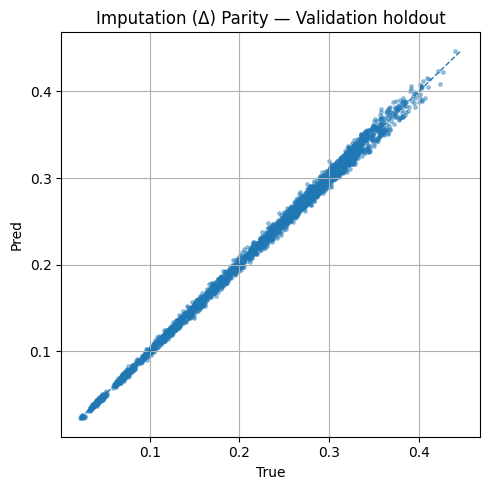

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_impute_parity_test_delta.png


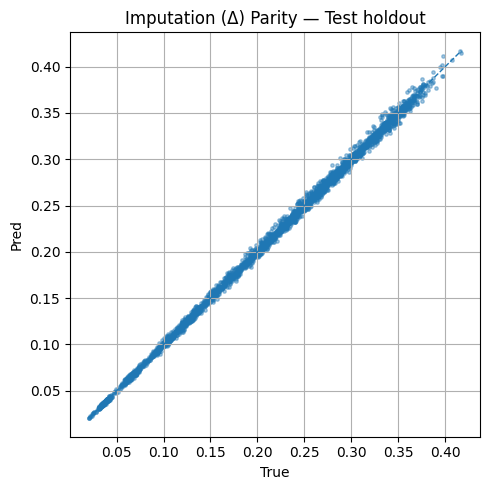

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_forecast_rmse_vs_h_test_H14.png


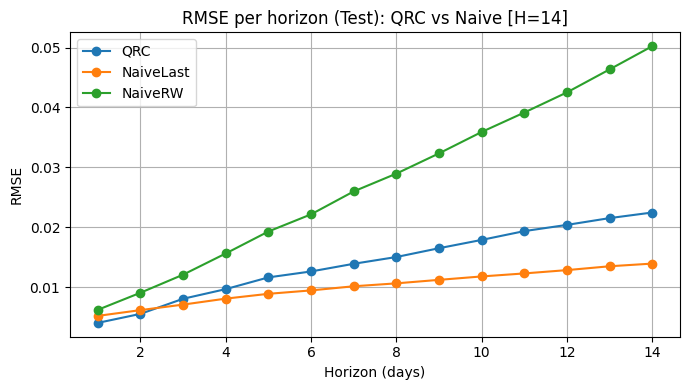

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_forecast_rmse_vs_h_val_H14.png


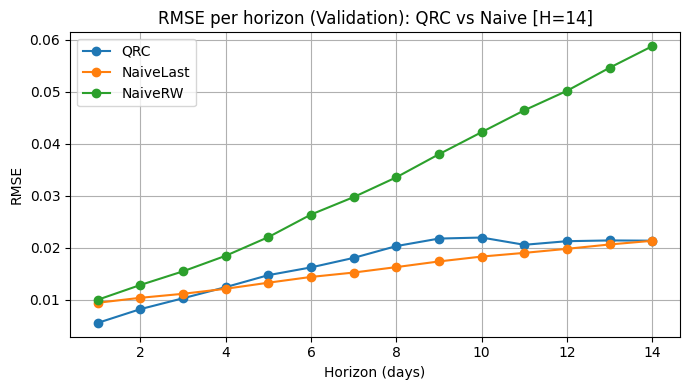

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_overlay_QRC_vs_Naive_h1_H14.png


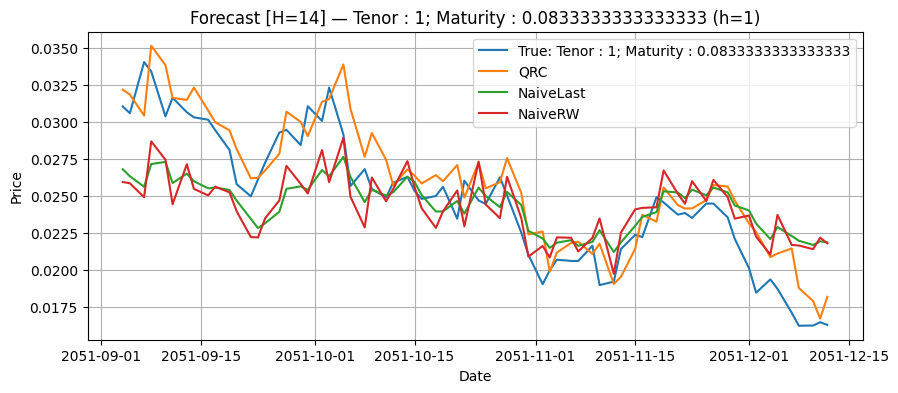

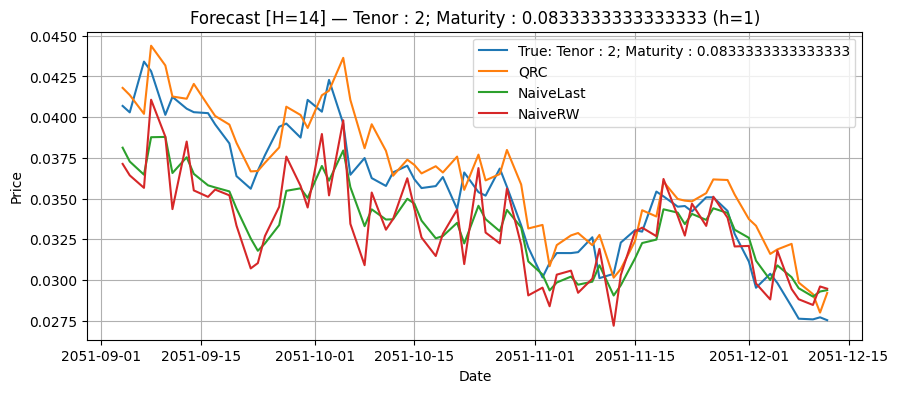

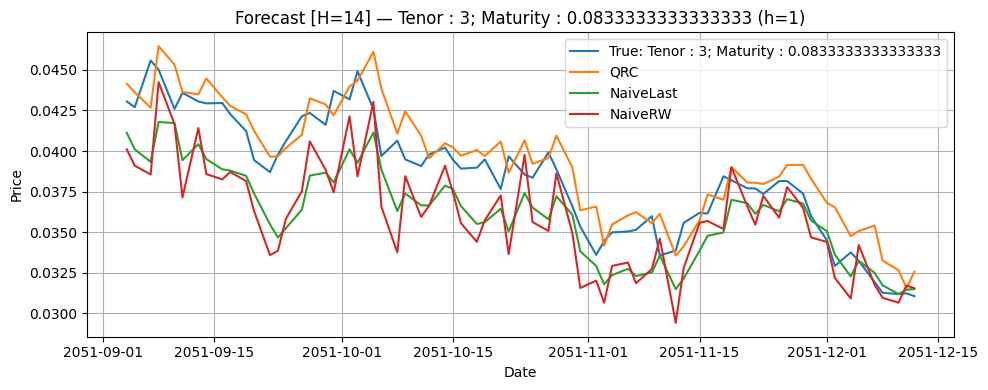

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_overlay_QRC_vs_Naive_h14_H14.png


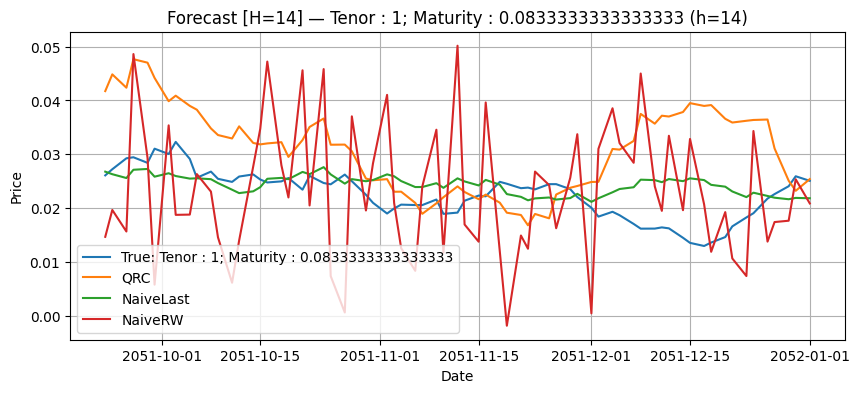

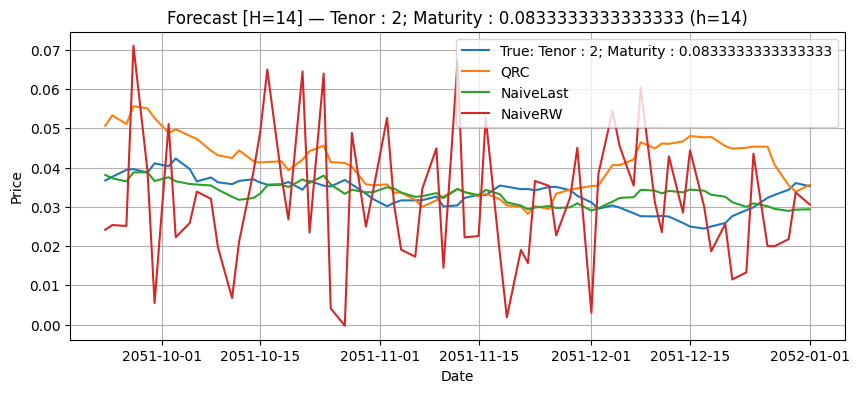

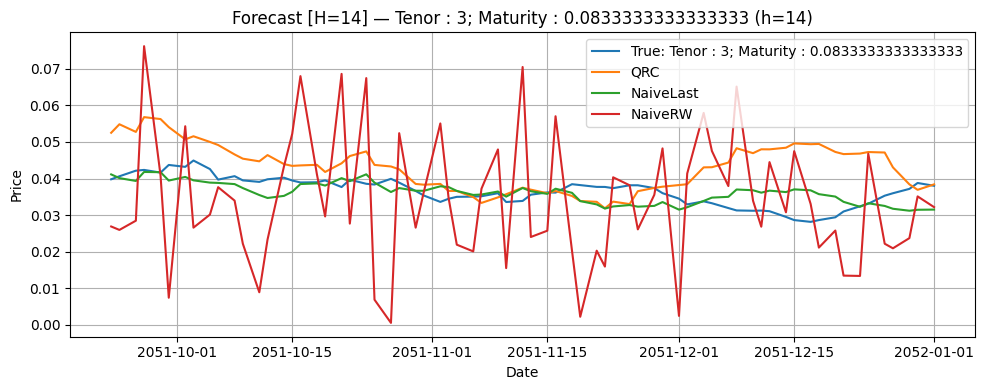

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_parity_h1_H14.png


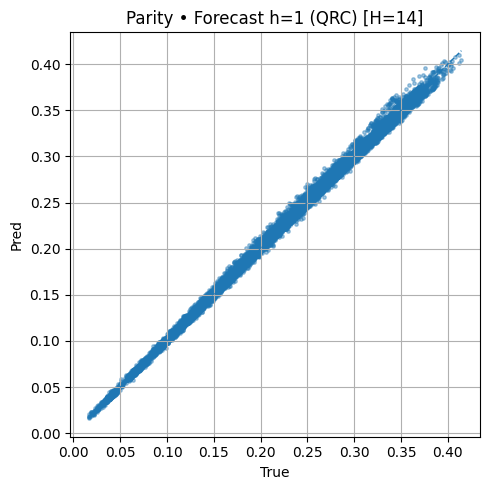

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_err_hist_h1_H14.png


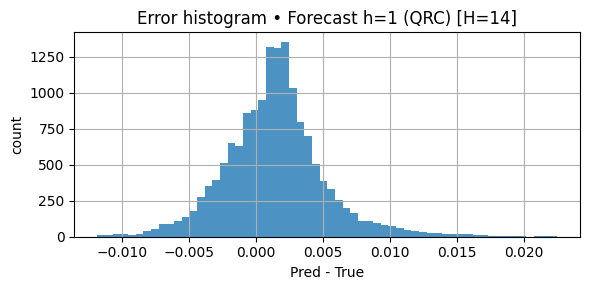

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_rmse_heatmap_h1_H14.png


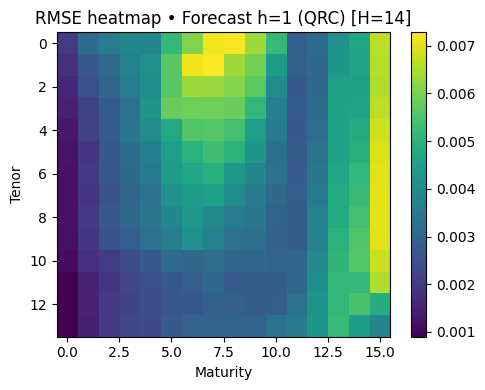

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_forecast_rmse_vs_h_test_H3.png


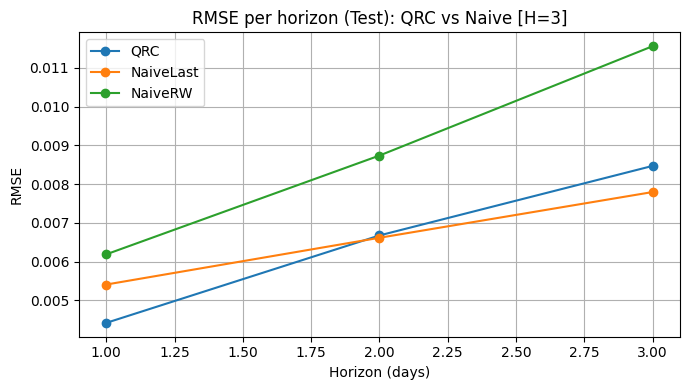

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_forecast_rmse_vs_h_val_H3.png


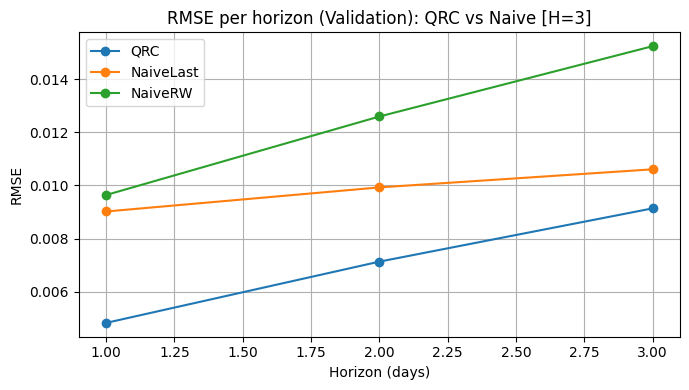

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_overlay_QRC_vs_Naive_h1_H3.png


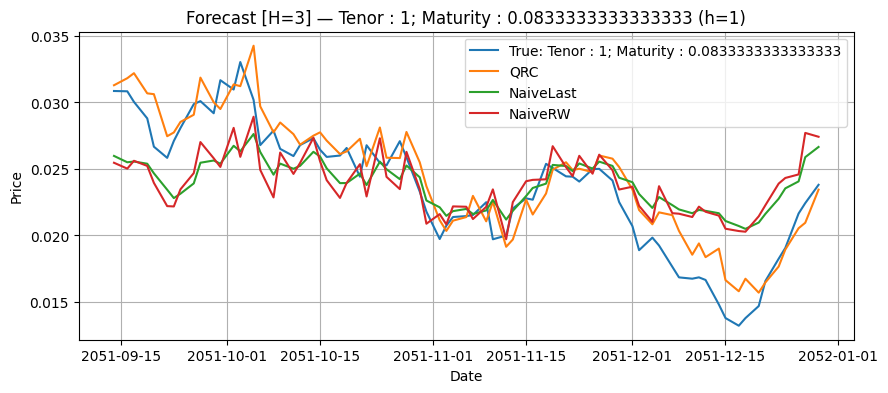

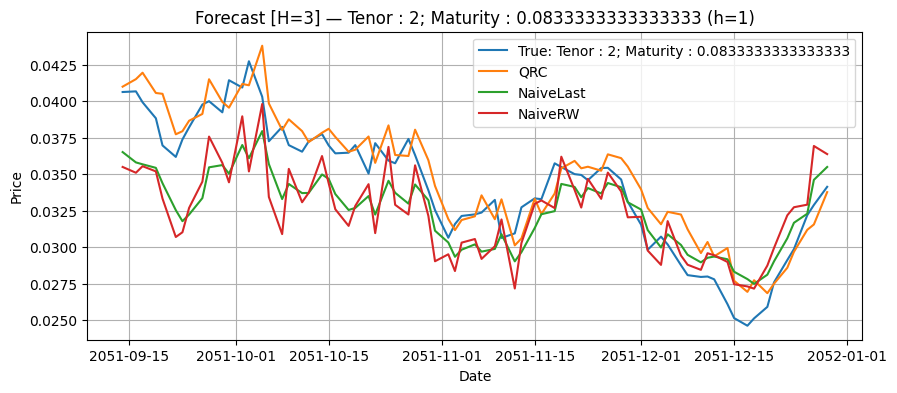

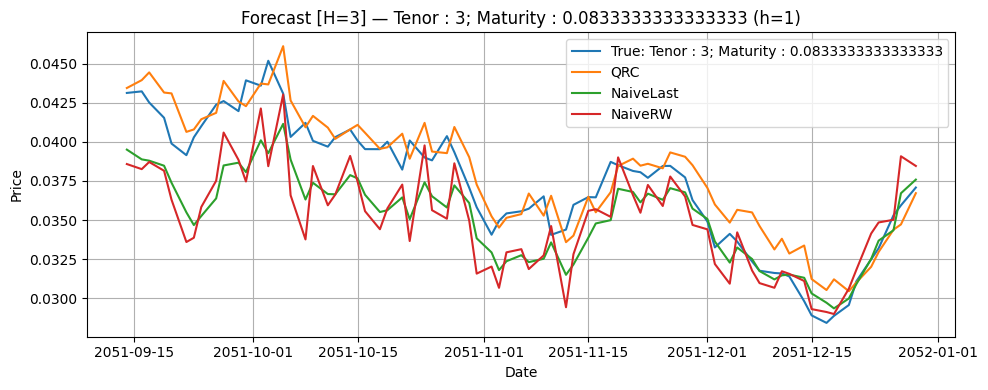

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_overlay_QRC_vs_Naive_h3_H3.png


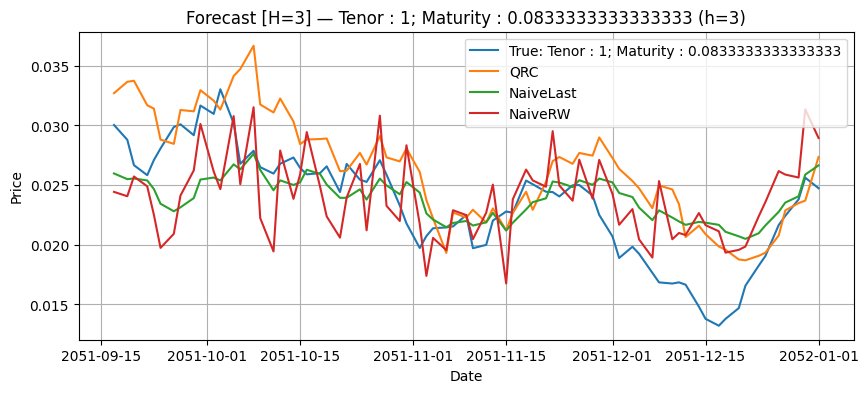

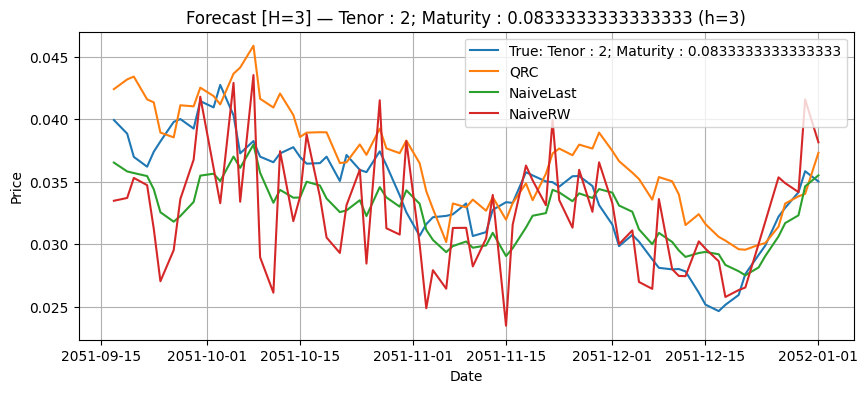

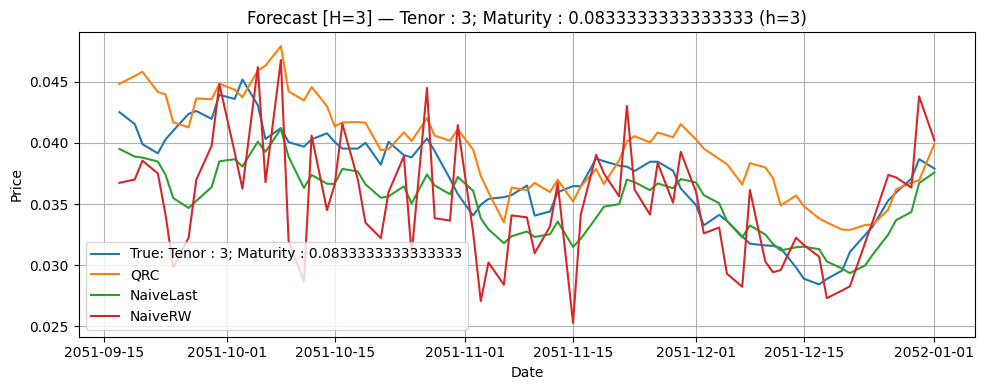

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_parity_h1_H3.png


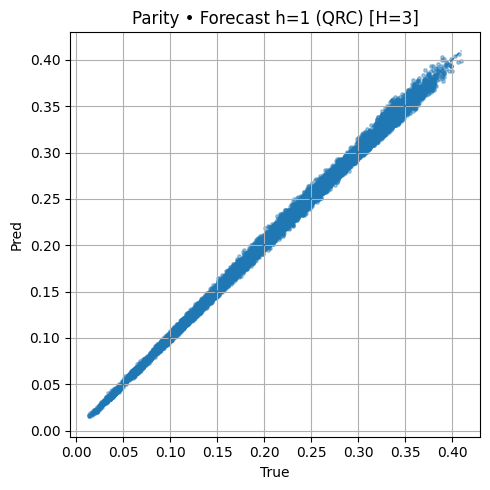

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_err_hist_h1_H3.png


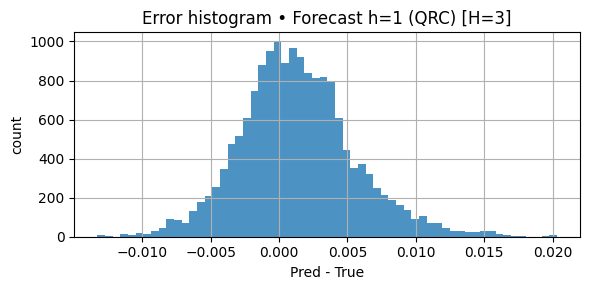

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_rmse_heatmap_h1_H3.png


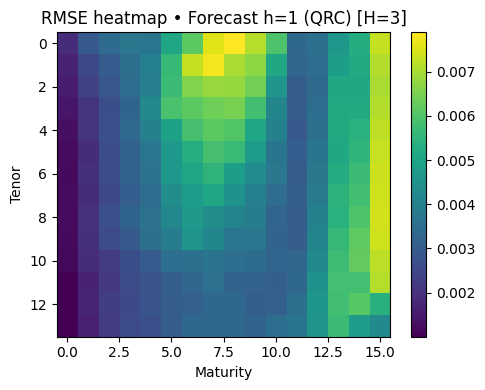

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_model_bar_H14.png


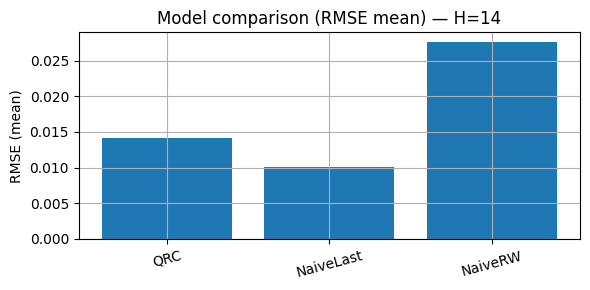

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_model_bar_H3.png


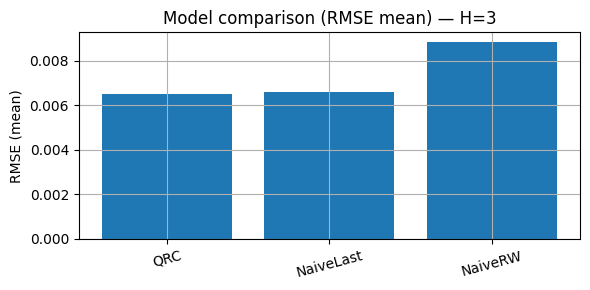


=== SUMMARY ===
Imputation(Δ): QRC vs Prev-day (RMSE, Test) = 0.003564 vs 0.003360
Forecast(H=14): Test RMSE mean — QRC=0.014214, Last=0.010119, RW=0.027576
Forecast(H=3): Test RMSE mean — QRC=0.006522, Last=0.006607, RW=0.008829
[Note] qubits=6, depth=2, use_pair(H=14)=True, EXOG lags=[0, 1, 5, 22]


In [12]:
# ================================
# Cell 3 — Visualization (ver3)
# ================================
outdir = OUTDIR

# A) Imputation (Δ)
print("\n[A] Imputation (Δ) — masked metrics")
print(f" Val QRC RMSE={IMP['val_masked']['RMSE']:.6f} (n={IMP['val_masked']['count']}) | Prev={IMP['val_masked_baseline']['RMSE']:.6f}")
print(f" Test QRC RMSE={IMP['test_masked']['RMSE']:.6f} (n={IMP['test_masked']['count']}) | Prev={IMP['test_masked_baseline']['RMSE']:.6f}")
parity_plot(IMP["true_val_holdout"].reshape(-1,1), IMP["pred_val_holdout"].reshape(-1,1),
            title="Imputation (Δ) Parity — Validation holdout")
savefig(os.path.join(outdir, "fig_impute_parity_val_delta.png"))
parity_plot(IMP["true_test_holdout"].reshape(-1,1), IMP["pred_test_holdout"].reshape(-1,1),
            title="Imputation (Δ) Parity — Test holdout")
savefig(os.path.join(outdir, "fig_impute_parity_test_delta.png"))

# B) Forecast（H=14/H=3）：RMSE vs h, overlay(h=1 / h=H), parity/hist/heatmap(h=1)
for H in (14, 3):
    FC = ART_FC[H]
    plot_rmse_vs_h(FC["df_te"], title=f"RMSE per horizon (Test): QRC vs Naive [H={H}]")
    savefig(os.path.join(outdir, f"fig_forecast_rmse_vs_h_test_H{H}.png"))
    plot_rmse_vs_h(FC["df_val"], title=f"RMSE per horizon (Validation): QRC vs Naive [H={H}]")
    savefig(os.path.join(outdir, f"fig_forecast_rmse_vs_h_val_H{H}.png"))

    # overlay: h=1, h=H
    plot_forecast_overlay_with_baselines(FC["dates_by_h"], FC["true_te"], FC["pred_te"], FC["last_te"], FC["rw_te"],
                                         FC["feature_cols"], horizon_idx=0,   top_k=3, title_prefix=f"Forecast [H={H}]")
    savefig(os.path.join(outdir, f"fig_overlay_QRC_vs_Naive_h1_H{H}.png"))
    plot_forecast_overlay_with_baselines(FC["dates_by_h"], FC["true_te"], FC["pred_te"], FC["last_te"], FC["rw_te"],
                                         FC["feature_cols"], horizon_idx=H-1, top_k=3, title_prefix=f"Forecast [H={H}]")
    savefig(os.path.join(outdir, f"fig_overlay_QRC_vs_Naive_h{H}_H{H}.png"))

    # h=1 の詳細
    y_true_h1 = FC["true_te"][:, 0, :]
    y_pred_h1 = FC["pred_te"][:, 0, :]
    parity_plot(y_true_h1, y_pred_h1, title=f"Parity • Forecast h=1 (QRC) [H={H}]")
    savefig(os.path.join(outdir, f"fig_parity_h1_H{H}.png"))
    error_hist(y_true_h1, y_pred_h1, title=f"Error histogram • Forecast h=1 (QRC) [H={H}]")
    savefig(os.path.join(outdir, f"fig_err_hist_h1_H{H}.png"))
    rmse_heatmap_by_grid(y_true_h1, y_pred_h1, FC["feature_cols"], title=f"RMSE heatmap • Forecast h=1 (QRC) [H={H}]")
    savefig(os.path.join(outdir, f"fig_rmse_heatmap_h1_H{H}.png"))

# C) Model bars
def plot_model_bar(means_dict, title="Model comparison (RMSE mean)", out_png=None):
    names = list(means_dict.keys()); vals = [means_dict[k] for k in names]
    plt.figure(figsize=(6,3))
    plt.bar(range(len(names)), vals)
    plt.xticks(range(len(names)), names, rotation=15)
    plt.ylabel("RMSE (mean)"); plt.title(title); plt.grid(True); plt.tight_layout()
    if out_png: plt.savefig(out_png, dpi=300); print(f"[SAVE] {out_png}")
    plt.show()

plot_model_bar(ART_MODEL["H14"], title="Model comparison (RMSE mean) — H=14",
               out_png=os.path.join(outdir, "fig_model_bar_H14.png"))
plot_model_bar(ART_MODEL["H3"], title="Model comparison (RMSE mean) — H=3",
               out_png=os.path.join(outdir, "fig_model_bar_H3.png"))

# D) Summary
print("\n=== SUMMARY ===")
print(f"Imputation(Δ): QRC vs Prev-day (RMSE, Test) = {IMP['test_masked']['RMSE']:.6f} vs {IMP['test_masked_baseline']['RMSE']:.6f}")
for H in (14,3):
    print(f"Forecast(H={H}): Test RMSE mean — QRC={ART_FC[H]['df_te']['QRC']['RMSE'].mean():.6f}, "
          f"Last={ART_FC[H]['df_te']['NaiveLast']['RMSE'].mean():.6f}, "
          f"RW={ART_FC[H]['df_te']['NaiveRW']['RMSE'].mean():.6f}")
print(f"[Note] qubits={N_QUBITS}, depth={DEPTH}, use_pair(H=14)={CFG_FC[14]['use_pair']}, EXOG lags={EXOG_LAGS}")


[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_qubits_vs_mse_H3_excl8.png


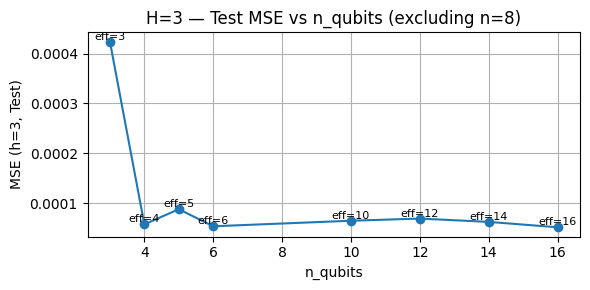

[SAVE] fig_qubits_vs_mse_H3_excl8.png


In [20]:
# ================================
# Cell 3b — H=3 n_qubits スイープ：MSE vs qubits（n=8を除外）
# ================================
outdir = OUTDIR

if 'QSWEEP_RES' in globals() and len(QSWEEP_RES):
    df_qs = pd.DataFrame(QSWEEP_RES).sort_values("n_qubits")

    # --- ★ n=8 を除外 ---
    df_plot = df_qs[df_qs["n_qubits"] != 8]

    plt.figure(figsize=(6,3))
    plt.plot(df_plot["n_qubits"], df_plot["MSE_h3"], marker="o")
    for _, r in df_plot.iterrows():
        plt.text(r["n_qubits"], r["MSE_h3"], f"eff={int(r['nq_eff'])}",
                 ha="center", va="bottom", fontsize=8)
    plt.xlabel("n_qubits"); plt.ylabel("MSE (h=3, Test)")
    plt.title("H=3 — Test MSE vs n_qubits (excluding n=8)")
    plt.grid(True)
    savefig(os.path.join(outdir, "fig_qubits_vs_mse_H3_excl8.png"))
    print(f"[SAVE] fig_qubits_vs_mse_H3_excl8.png")
else:
    print("[QSWEEP] no results to plot — run Cell 2b first.")


[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_qubits_vs_mse_H3_excl8.png


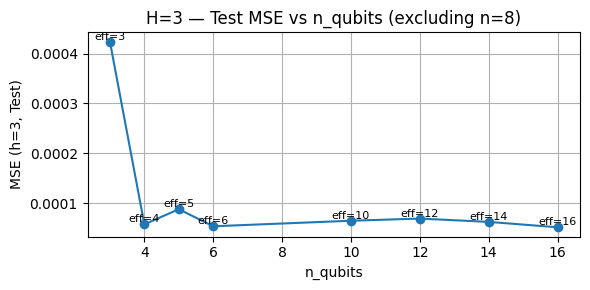

[SAVE] fig_qubits_vs_mse_H3_excl8.png
[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_qubits_vs_mse_H3_excl8_log.png


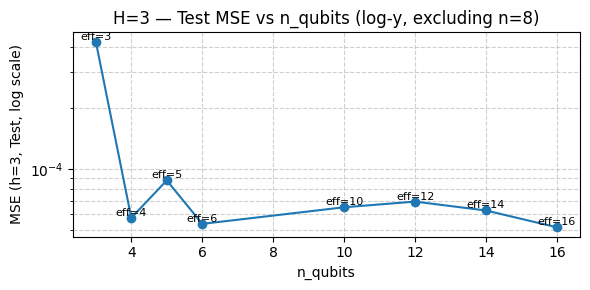

[SAVE] fig_qubits_vs_mse_H3_excl8_log.png


In [21]:
# ================================
# Cell 3b — H=3 n_qubits スイープ：MSE vs qubits（n=8除外＋対数プロット付き）
# ================================
outdir = OUTDIR

if 'QSWEEP_RES' in globals() and len(QSWEEP_RES):
    df_qs = pd.DataFrame(QSWEEP_RES).sort_values("n_qubits")

    # --- n=8 を除外 ---
    df_plot = df_qs[df_qs["n_qubits"] != 8]

    # ---------- ① 通常スケール ----------
    plt.figure(figsize=(6,3))
    plt.plot(df_plot["n_qubits"], df_plot["MSE_h3"], marker="o")
    for _, r in df_plot.iterrows():
        plt.text(r["n_qubits"], r["MSE_h3"], f"eff={int(r['nq_eff'])}",
                 ha="center", va="bottom", fontsize=8)
    plt.xlabel("n_qubits"); plt.ylabel("MSE (h=3, Test)")
    plt.title("H=3 — Test MSE vs n_qubits (excluding n=8)")
    plt.grid(True)
    savefig(os.path.join(outdir, "fig_qubits_vs_mse_H3_excl8.png"))
    print(f"[SAVE] fig_qubits_vs_mse_H3_excl8.png")

    # ---------- ② 対数スケール ----------
    plt.figure(figsize=(6,3))
    plt.plot(df_plot["n_qubits"], df_plot["MSE_h3"], marker="o")
    for _, r in df_plot.iterrows():
        plt.text(r["n_qubits"], r["MSE_h3"], f"eff={int(r['nq_eff'])}",
                 ha="center", va="bottom", fontsize=8)
    plt.xlabel("n_qubits"); plt.ylabel("MSE (h=3, Test, log scale)")
    plt.title("H=3 — Test MSE vs n_qubits (log-y, excluding n=8)")
    plt.yscale("log")              # ★縦軸を対数スケールに変更
    plt.grid(True, which="both", ls="--", alpha=0.6)
    savefig(os.path.join(outdir, "fig_qubits_vs_mse_H3_excl8_log.png"))
    print(f"[SAVE] fig_qubits_vs_mse_H3_excl8_log.png")

else:
    print("[QSWEEP] no results to plot — run Cell 2b first.")
